In [1]:
import ticktack
from ticktack import fitting as ticktackfit
import ticktacktoe
from ticktacktoe import fitting as ticktacktoefit
from time import process_time
from os import getcwd
from plotnine import *
from pandas import DataFrame

In [2]:
MODELS = { # This dictionary contains the units for the fluxes and production function
    "Guttler14": {  # Units of the Guttler 2014 paper
        "production_rate_units": "atoms/cm^2/s",    # Units of the production rate 
        "flow_rate_units": "Gt/yr"                  # Units of the fluxes
    },
    "Brehm21": {    # Units used by the Brehm, et. al. paper
        "production_rate_units": "kg/yr",    # Units of the production rate
        "flow_rate_units": "Gt/yr"           # Units of the fluxes
    },
    "Buntgen18": {  # The units used by the Buntgen 2018 paper
        "production_rate_units": "atoms/cm^2/s",    # Units of the production function
        "flow_rate_units": "Gt/yr"                  # Units of the fluxes 
    },
    "Miyake17": {   # The units used by the Miyake 2017 et. al. paper
        "production_rate_units": "atoms/cm^2/s",    # Units of the production function 
        "flow_rate_units": "1/yr"                   # Units of the fluxes.
    }
}

In [3]:
MODULES = {
    "ticktack": [ticktack, ticktackfit], 
    "ticktacktoe": [ticktacktoe, ticktacktoefit]
}

The following cell is not initializing the model correctly

In [4]:
model_fitting_objects = {
    "ticktack": {
        "Guttler14": None, "Brehm21": None,
        "Buntgen18": None, "Miyake17": None
    },
    "ticktacktoe": {
        "Guttler14": None, "Brehm21": None,
        "Buntgen18": None, "Miyake17": None
    }
}

for module in MODULES:
    for model in MODELS:
        carbon_box_model = MODULES[module][0].load_presaved_model(model, 
        production_rate_units=MODELS[model]["production_rate_units"], 
        flow_rate_units=MODELS[model]["flow_rate_units"])

        fitting_object = MODULES[module][1].SingleFitter(
            carbon_box_model, cbm_model=model)
        fitting_object.load_data(f"{getcwd()}/datasets/775AD/NH/Miyake12_Cedar.csv")
        fitting_object.prepare_function(model="simple_sinusoid")

        model_fitting_objects[module][model] = fitting_object

INFO[2022-01-16 14:10:25,715]: Unable to initialize backend 'tpu_driver': Not found: Unable to find driver in registry given worker: 
INFO[2022-01-16 14:10:25,716]: Unable to initialize backend 'gpu': Not found: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
INFO[2022-01-16 14:10:25,718]: Unable to initialize backend 'tpu': Invalid argument: TpuPlatform is not available.
WARNING[2022-01-16 14:10:25,720]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [5]:
tolerance_frame = {
    "module": [], 
    "type": [], 
    "tolerance": [], 
    "year": [], 
    "dc14": []
}

time_frame = {
    "module": [], 
    "type": [], 
    "time": [],
    "tolerance": []
}

toleracne_range = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]

In [6]:
for module in model_fitting_objects:
    for model in model_fitting_objects[module]:
        timer = process_time()
        fit_array = model_fitting_objects[module][model].dc14(
            params=(774.86, 0.25, 0.8, 6.44), rtol=1e-5, atol=1e-5)
        timer = process_time() - timer
        fit_shape = len(fit_array)

In [ ]:
for module in model_fitting_objects:
    for model in model_fitting_objects[module]:
        for tol in toleracne_range:
            timer = process_time()
            fit_array = model_fitting_objects[module][model].dc14(
                params=(774.86, 0.25, 0.8, 6.44), rtol=tol, atol=tol)
            timer = process_time() - timer
            fit_shape = len(fit_array)

            tolerance_frame["module"].extend([module for _ in range(fit_shape)])
            tolerance_frame["type"].extend([model for _ in range(fit_shape)])
            tolerance_frame["tolerance"].extend([tol for _ in range(fit_shape)])
            tolerance_frame["year"].extend([year for year in range(fit_shape)])
            tolerance_frame["dc14"].extend(fit_array)
            
            time_frame["module"].append(module)
            time_frame["type"].append(model)
            time_frame["time"].append(timer)
            time_frame["tolerance"].append(tol)

/home/jordan/anaconda3/envs/beyondticktack/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


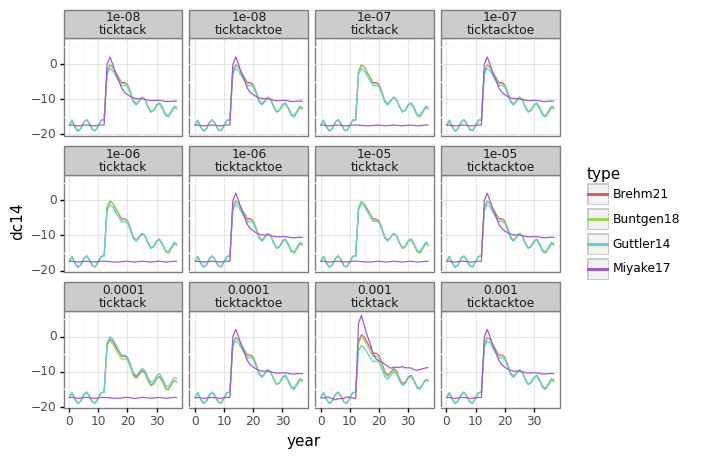

<ggplot: (8742456479449)>

In [ ]:
tolerance_frame = DataFrame(tolerance_frame)
(ggplot(tolerance_frame, aes(x="year", y="dc14", color="type"))
    + geom_line()
    + theme_bw()
    + facet_wrap(facets="~ tolerance + module"))

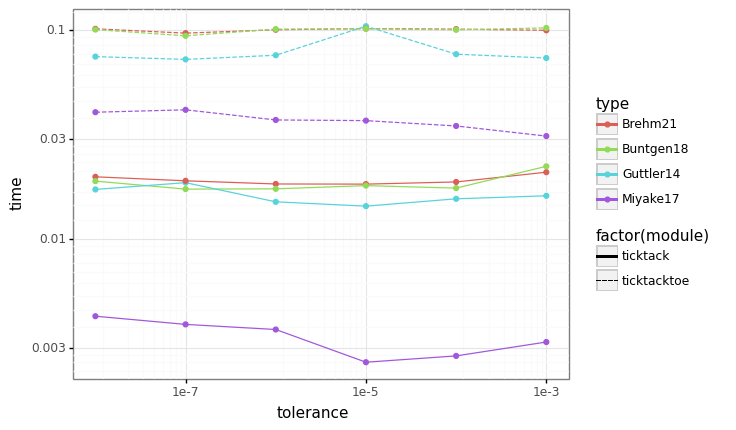

<ggplot: (8742385034638)>

In [ ]:
time_frame = DataFrame(time_frame)
(ggplot(time_frame, aes(x="tolerance", y="time", color="type", linetype="factor(module)"))
    + geom_line()
    + geom_point() 
    + scale_x_log10()
    + scale_y_log10()
    + theme_bw())